In [1]:
import li.analysis as la
import li.EvaluationHelpers as eh

import os
import numpy as np
import matplotlib.pyplot as plt

from lithium.li.analysis import gauss_parab

# Data Loading and Definition of Variables

In [2]:
# path to images
images_set = "E-Temperature_vs_B"

path_dir = "Z:/Archiv/2D/Experiment/2025/20250203/Images20250203/" + images_set + "/"
path_file = os.listdir(path_dir)

In [3]:
# grab loop variable names
variables = la.loop_variables(path_dir + path_file[0])[1]
var_vals = la.loop_variables(path_dir + path_file[0])[0]

In [4]:
variables

['i', 'FB_Img']

In [5]:
# experiment variables loaded from experiment control
info = la.GetImageMetadata(path_dir + path_file[-1])
info_sorted = dict(sorted(info[0].items(), key=lambda x: x[0].lower()))
# info_sorted

# Image Processing

In [6]:
%%time
# create initial dictionary with all raw images
images_raw = eh.createImageInfoList([path_dir], variables)

CPU times: total: 0 ns
Wall time: 204 ms


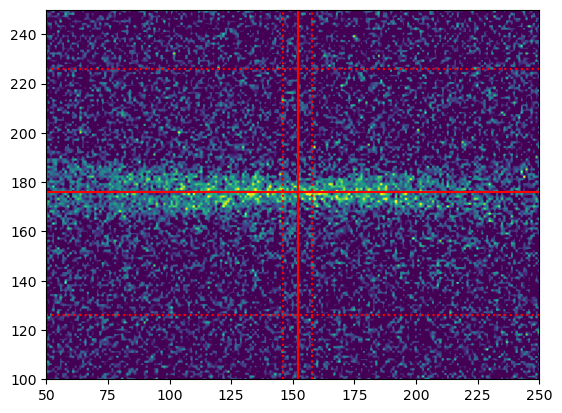

In [7]:
# determine optimal ROI
center = (176, 152)
h = 50
w = 6

single_prc = la.density_builder([images_raw[3]], variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = True)

plt.imshow(single_prc.iloc[0]["density"].data, vmin = 0, vmax = 3, cmap = "viridis")

plt.xlim(50, 250)
plt.ylim(100, 250)


plt.axhline(center[0], c = "red")
plt.axhline(center[0] - h, c = "red", ls = ":")
plt.axhline(center[0] + h, c = "red", ls = ":")

plt.axvline(center[1], c = "red")
plt.axvline(center[1] - w, c = "red", ls = ":")
plt.axvline(center[1] + w, c = "red", ls = ":")


plt.show()

In [8]:
%%time
# calculate all density images and apply mask
images_prc = la.density_builder(images_raw, variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = False)

|████████████████████████████████████████| 400/400 [100%] in 40.5s (9.89/s)     
CPU times: total: 16.7 s
Wall time: 40.5 s


In [9]:
var_vals[1]

array([750., 760., 770., 780., 790., 800., 810., 820.])

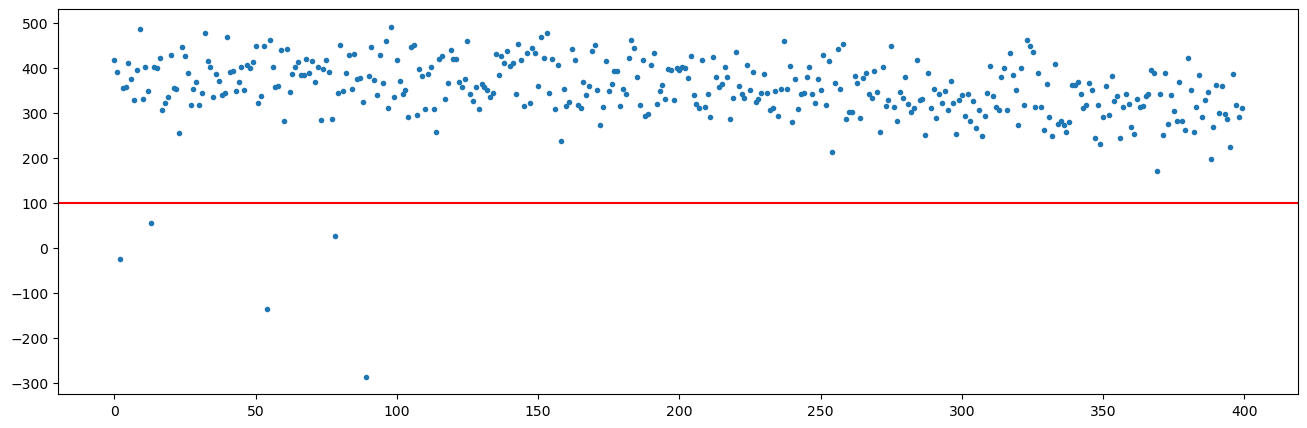

In [10]:
# filter out missed shots
bol = []

for rate in var_vals[1]:

    for i, im in images_prc[images_prc["FB_Img"] == rate].iterrows():
        bol.append(np.sum(im["density"].compressed()))

plt.figure(figsize = (16, 5))

plt.plot(bol, ".")
plt.axhline(100, c = "r")

plt.ylim(None, None)

plt.show()

In [11]:
%%time
# filter missed shots
images_fil = la.filter(images_prc, 100)

CPU times: total: 46.9 ms
Wall time: 31 ms


In [12]:
%%time
# group by loop variables and average over iterations
images_grp = la.group(images_fil, variables, "i")

CPU times: total: 469 ms
Wall time: 494 ms


In [13]:
%%time
# make T4 fits 
images_fit = la.T4_fit(images_grp)

CPU times: total: 188 ms
Wall time: 185 ms


In [15]:
%%time
# calculate response
# images_res = la.response(images_fit)

CPU times: total: 0 ns
Wall time: 0 ns


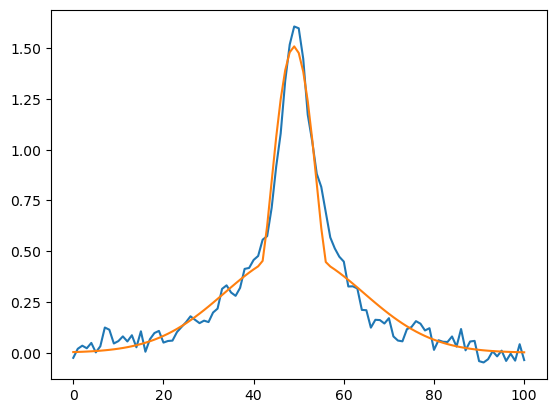

[4.86565079e-01 4.94624813e+01 2.20000000e+01 3.19384821e-24
 1.02255639e+00 7.24614585e+00]
12.406960659880378


In [24]:
field = 4

T4 = np.mean(images_fit["density"].iloc[field], axis = 1).compressed()
pos = np.arange(0, len(T4))

plt.plot(pos, T4)

plt.plot(la.gauss_parab(np.linspace(0, len(T4), len(T4)), images_fit["T4_params"].iloc[field][0],
                                                          images_fit["T4_params"].iloc[field][1],
                                                          images_fit["T4_params"].iloc[field][2],
                                                          images_fit["T4_params"].iloc[field][3],
                                                          images_fit["T4_params"].iloc[field][4],
                                                          images_fit["T4_params"].iloc[field][5]))

# plt.plot(pos, parab(pos, 2.3, 50, 5))

plt.show()

print(images_fit["T4_params"].iloc[field])
print(images_fit["temperature"].iloc[field])

# Visualization